In [24]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
from graph_format import *
# load local model file and initialize model class
from model import ModelClass
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load original model

In [25]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)
%time model.simulate()

CPU times: total: 6min 16s
Wall time: 1min 21s
CPU times: total: 29.5 s
Wall time: 23.9 s


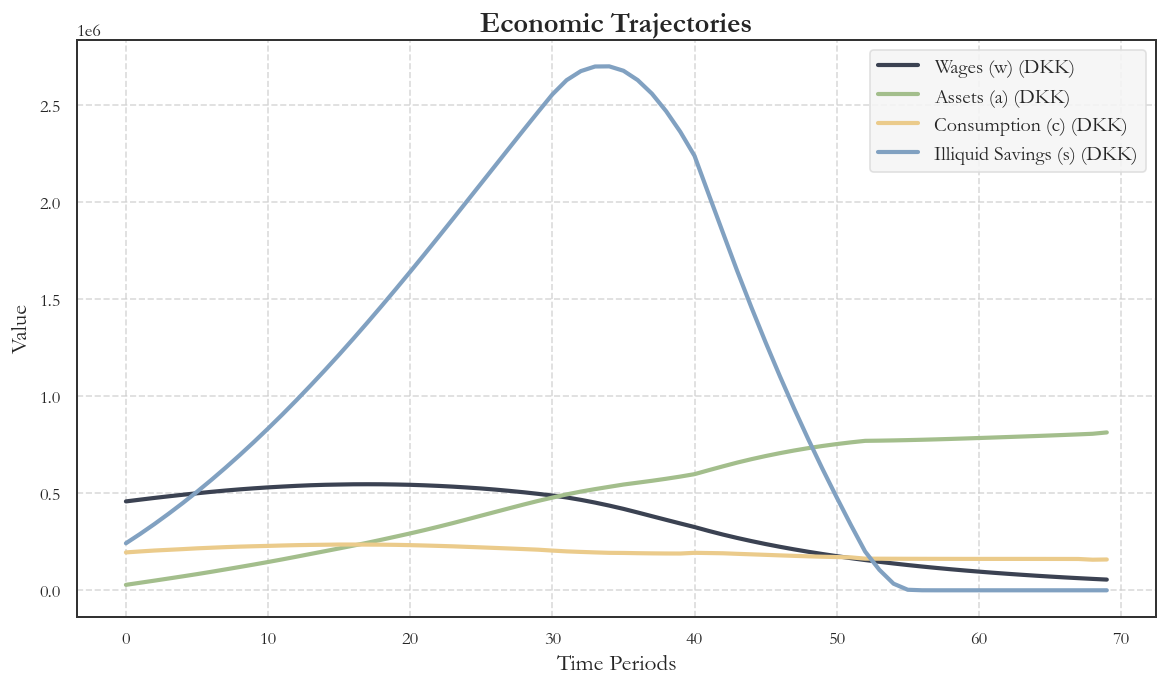

In [26]:
time = np.arange(par.T)
data_dict_basic = {
    "Wages (w)": {"data": np.mean(model.sim.w[:], axis=0), "unit": "DKK"},
    "Assets (a)": {"data": np.mean(model.sim.a[:], axis=0), "unit": "DKK"},
    "Consumption (c)": {"data": np.mean(model.sim.c[:], axis=0), "unit": "DKK"},
    "Illiquid Savings (s)": {"data": np.mean(model.sim.s[:], axis=0), "unit": "DKK"},
}

plot_simulation_one_graph(data_dict_basic, time, title="Economic Trajectories")

# Counter factual

In [27]:
# Change parameters and re-solve
theta = [par.early_benefit - 40_000]
theta_names = ['early_benefit']



# theta = [0.03]
# theta_names = ['r_a']


og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


# Compare models 

Expected welfare  before parameter changes: -27.18844133235654
Expected welfare after parameter changes: -27.222487690780643
Consumption at every age before the policy change must change with -0.9 pct. to keep the same utility, and analytically: -0.9 pct.
[9213. 9219. 9260. 9190. 9189. 9226. 9192. 9190. 9180. 9163. 9135. 9149.
 9134. 9080. 9030. 9067. 9028. 8995. 8979. 8931. 8894. 8846. 8806. 8788.
 8707. 8636. 8573. 8533. 8462. 8376. 7974. 6999. 6181. 5411. 4677. 4002.
 3378. 2809. 2379. 1949.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[9215. 9226. 9268. 9197. 9195. 9233. 9200. 9198. 9188. 9171. 9142. 9156.
 9142. 9087. 9038. 9075. 9036. 9003. 8987. 8939. 8902. 8852. 8814. 8796.
 8715. 8644. 8581. 8540. 8470. 8382. 7979. 7070. 6243. 5462. 4720. 4040.
 3399. 2826. 2392. 1958.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0. 

c:\Users\Peter\Design_retirement\WelfareMeasures.py:81: RuntimeWarning: Mean of empty slice
  sim_og_h = np.nanmean(sim_og_h_ex_1, axis=0)# age specific average
c:\Users\Peter\Design_retirement\WelfareMeasures.py:82: RuntimeWarning: Mean of empty slice
  sim_new_h = np.nanmean(sim_new_h_ex_1, axis=0) # age specific average


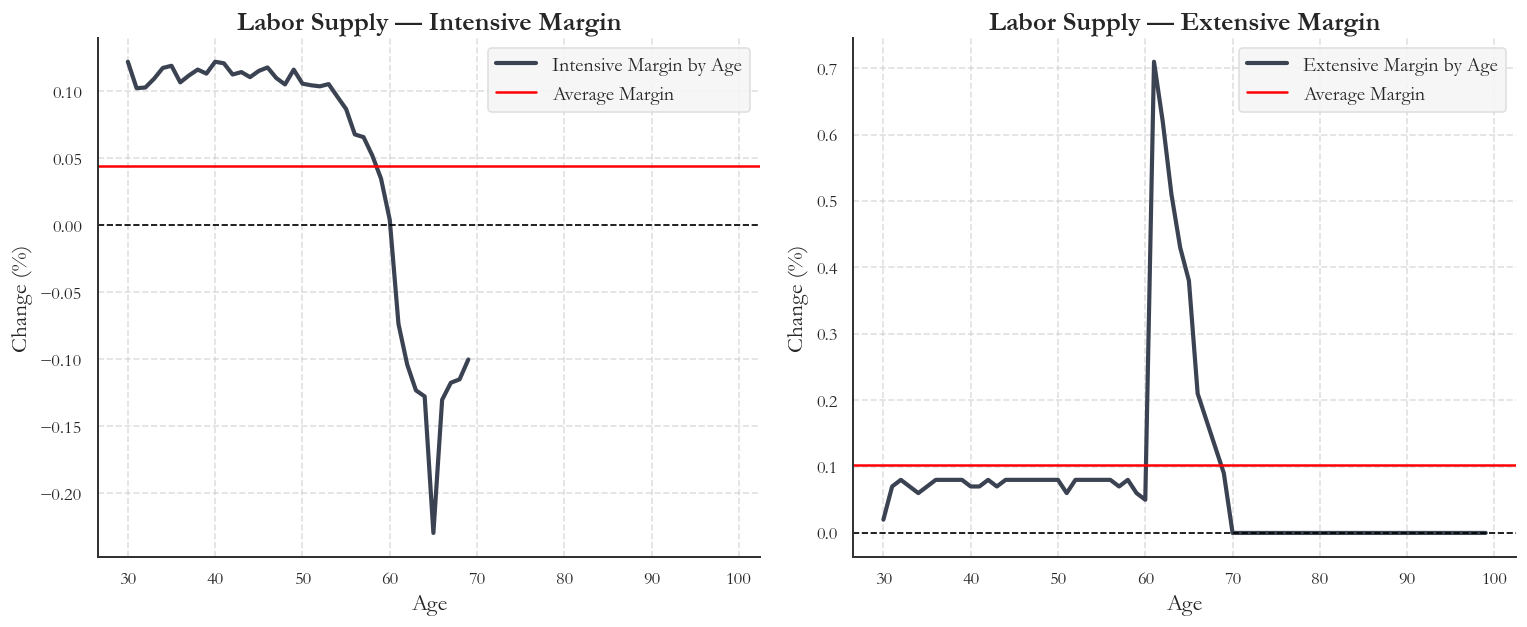

In [28]:
# Compare models 
consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, intensive_margin_age, extensive_margin_age = labor_elasticity(og_model, new_model)


plot_labor_margins_by_age(
    intensive_age=intensive_margin_age,
    extensive_age=extensive_margin_age,
    avg_intensive=intensive_margin,
    avg_extensive=extensive_margin,
    age_start=par.start_age,
    title_prefix="Labor Supply — ",
    save_title="counterfactual_labor_margins_by_age.png"
)

In [29]:
(np.sum(new_model.sim.h) - np.sum(og_model.sim.h))/np.sum(og_model.sim.h)

0.002445407099431008

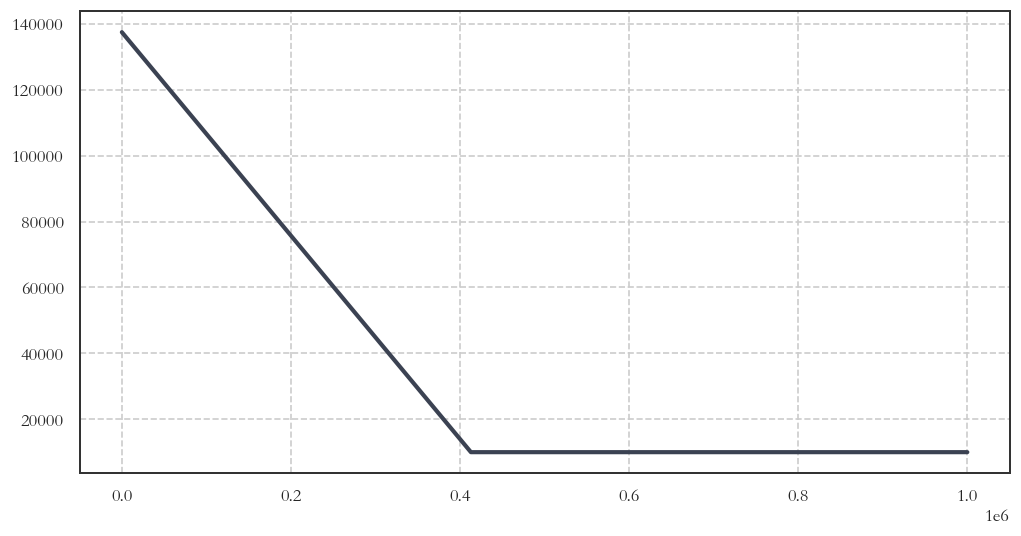

In [30]:
income_list = []

for income in range(1_000_000):
    income_list.append(max(par.chi_base, par.chi_total - income*par.rho))

plt.plot(income_list)

In [31]:
par.unemployment_benefit

array([123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  

# comparison of means

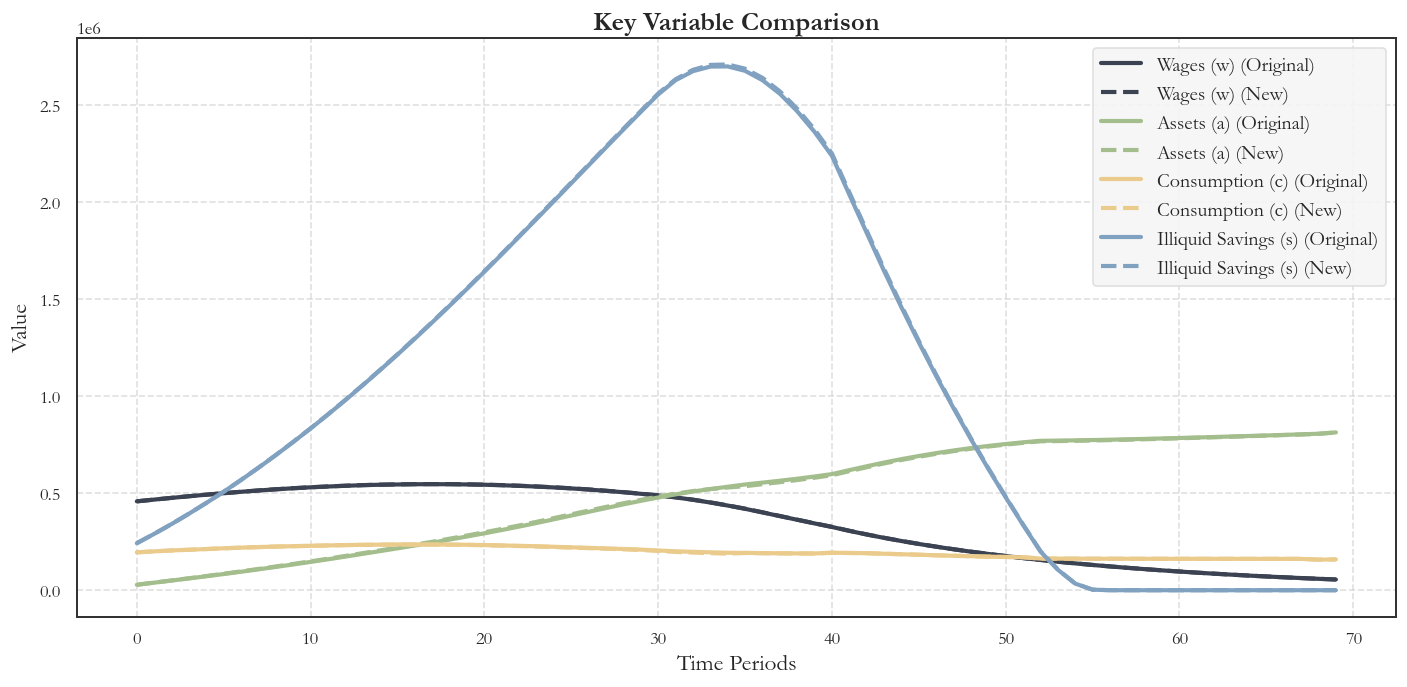

In [32]:
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

plot_comparison_single_panel(simulated_data_og, simulated_data_new, summary_vars, time, save_title="counterfactual_summary_vars.png")


C:\Users\Peter\AppData\Local\Temp\ipykernel_11280\65369719.py:5: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
C:\Users\Peter\AppData\Local\Temp\ipykernel_11280\65369719.py:17: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
C:\Users\Peter\AppData\Local\Temp\ipykernel_11280\65369719.py:29: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0)
C:\Users\Peter\AppData\Local\Temp\ipykernel_11280\65369719.py:30: RuntimeWarning: Mean of empty slice
  - np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),


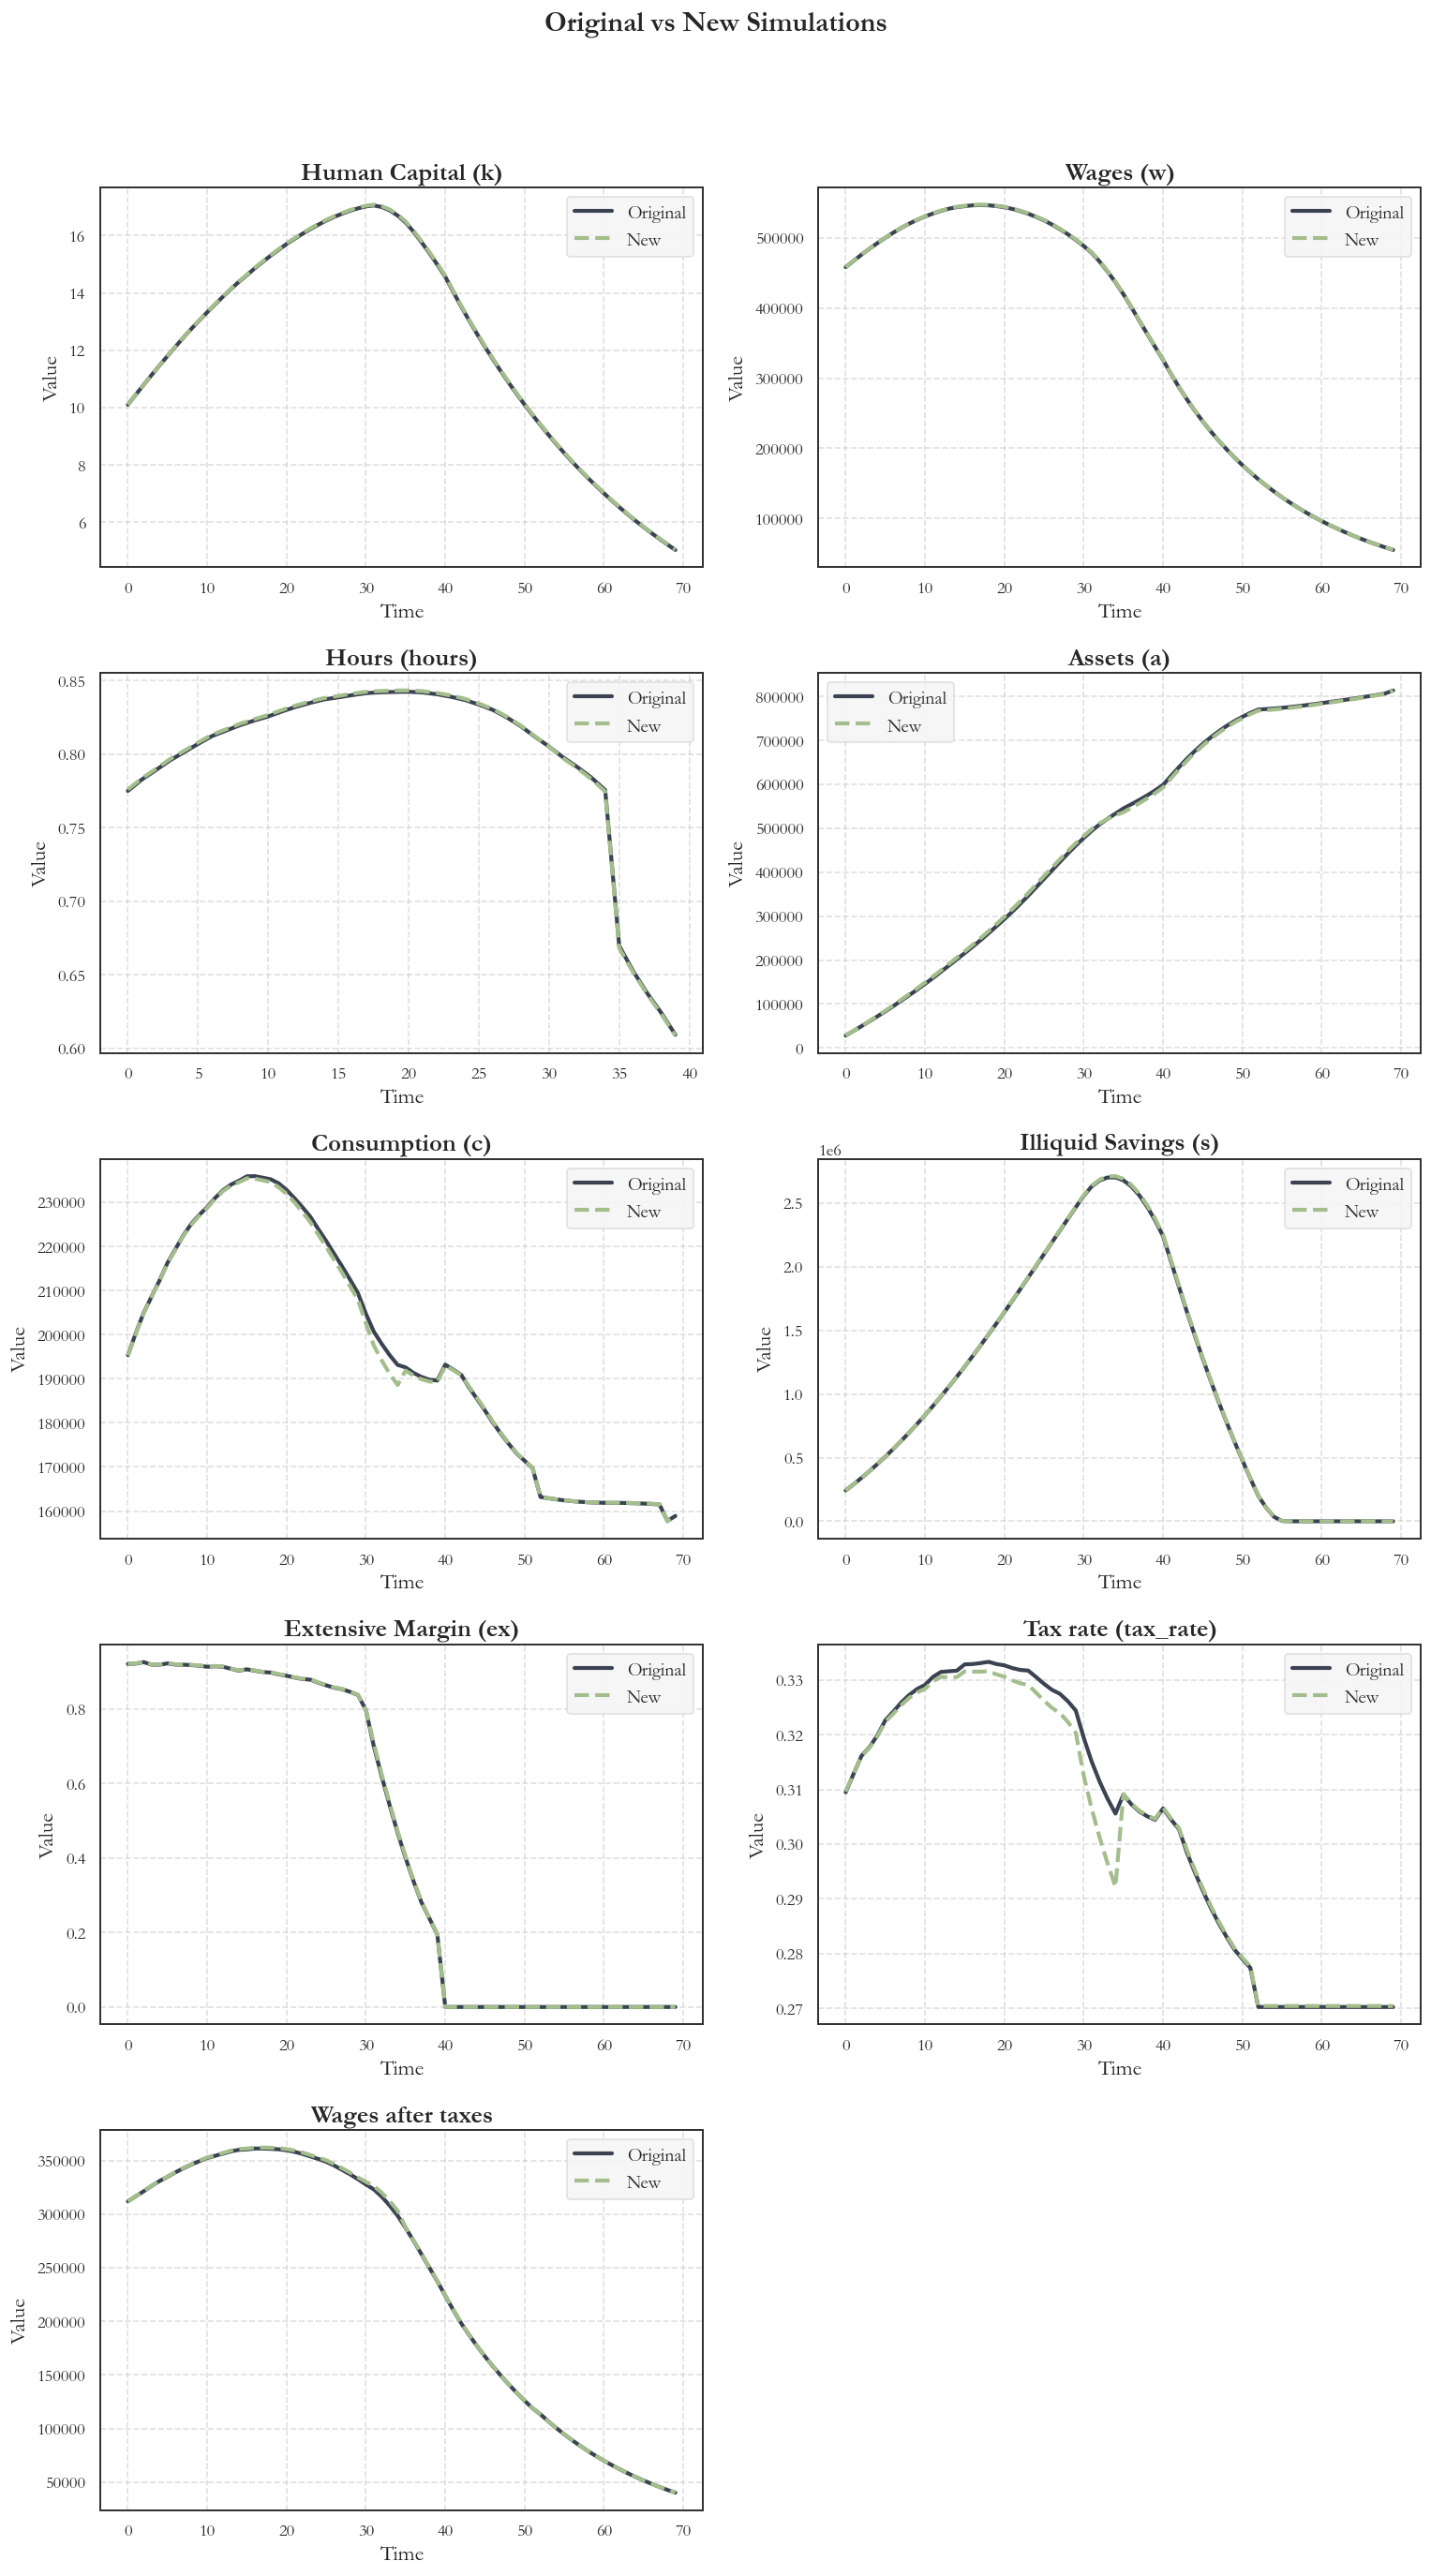

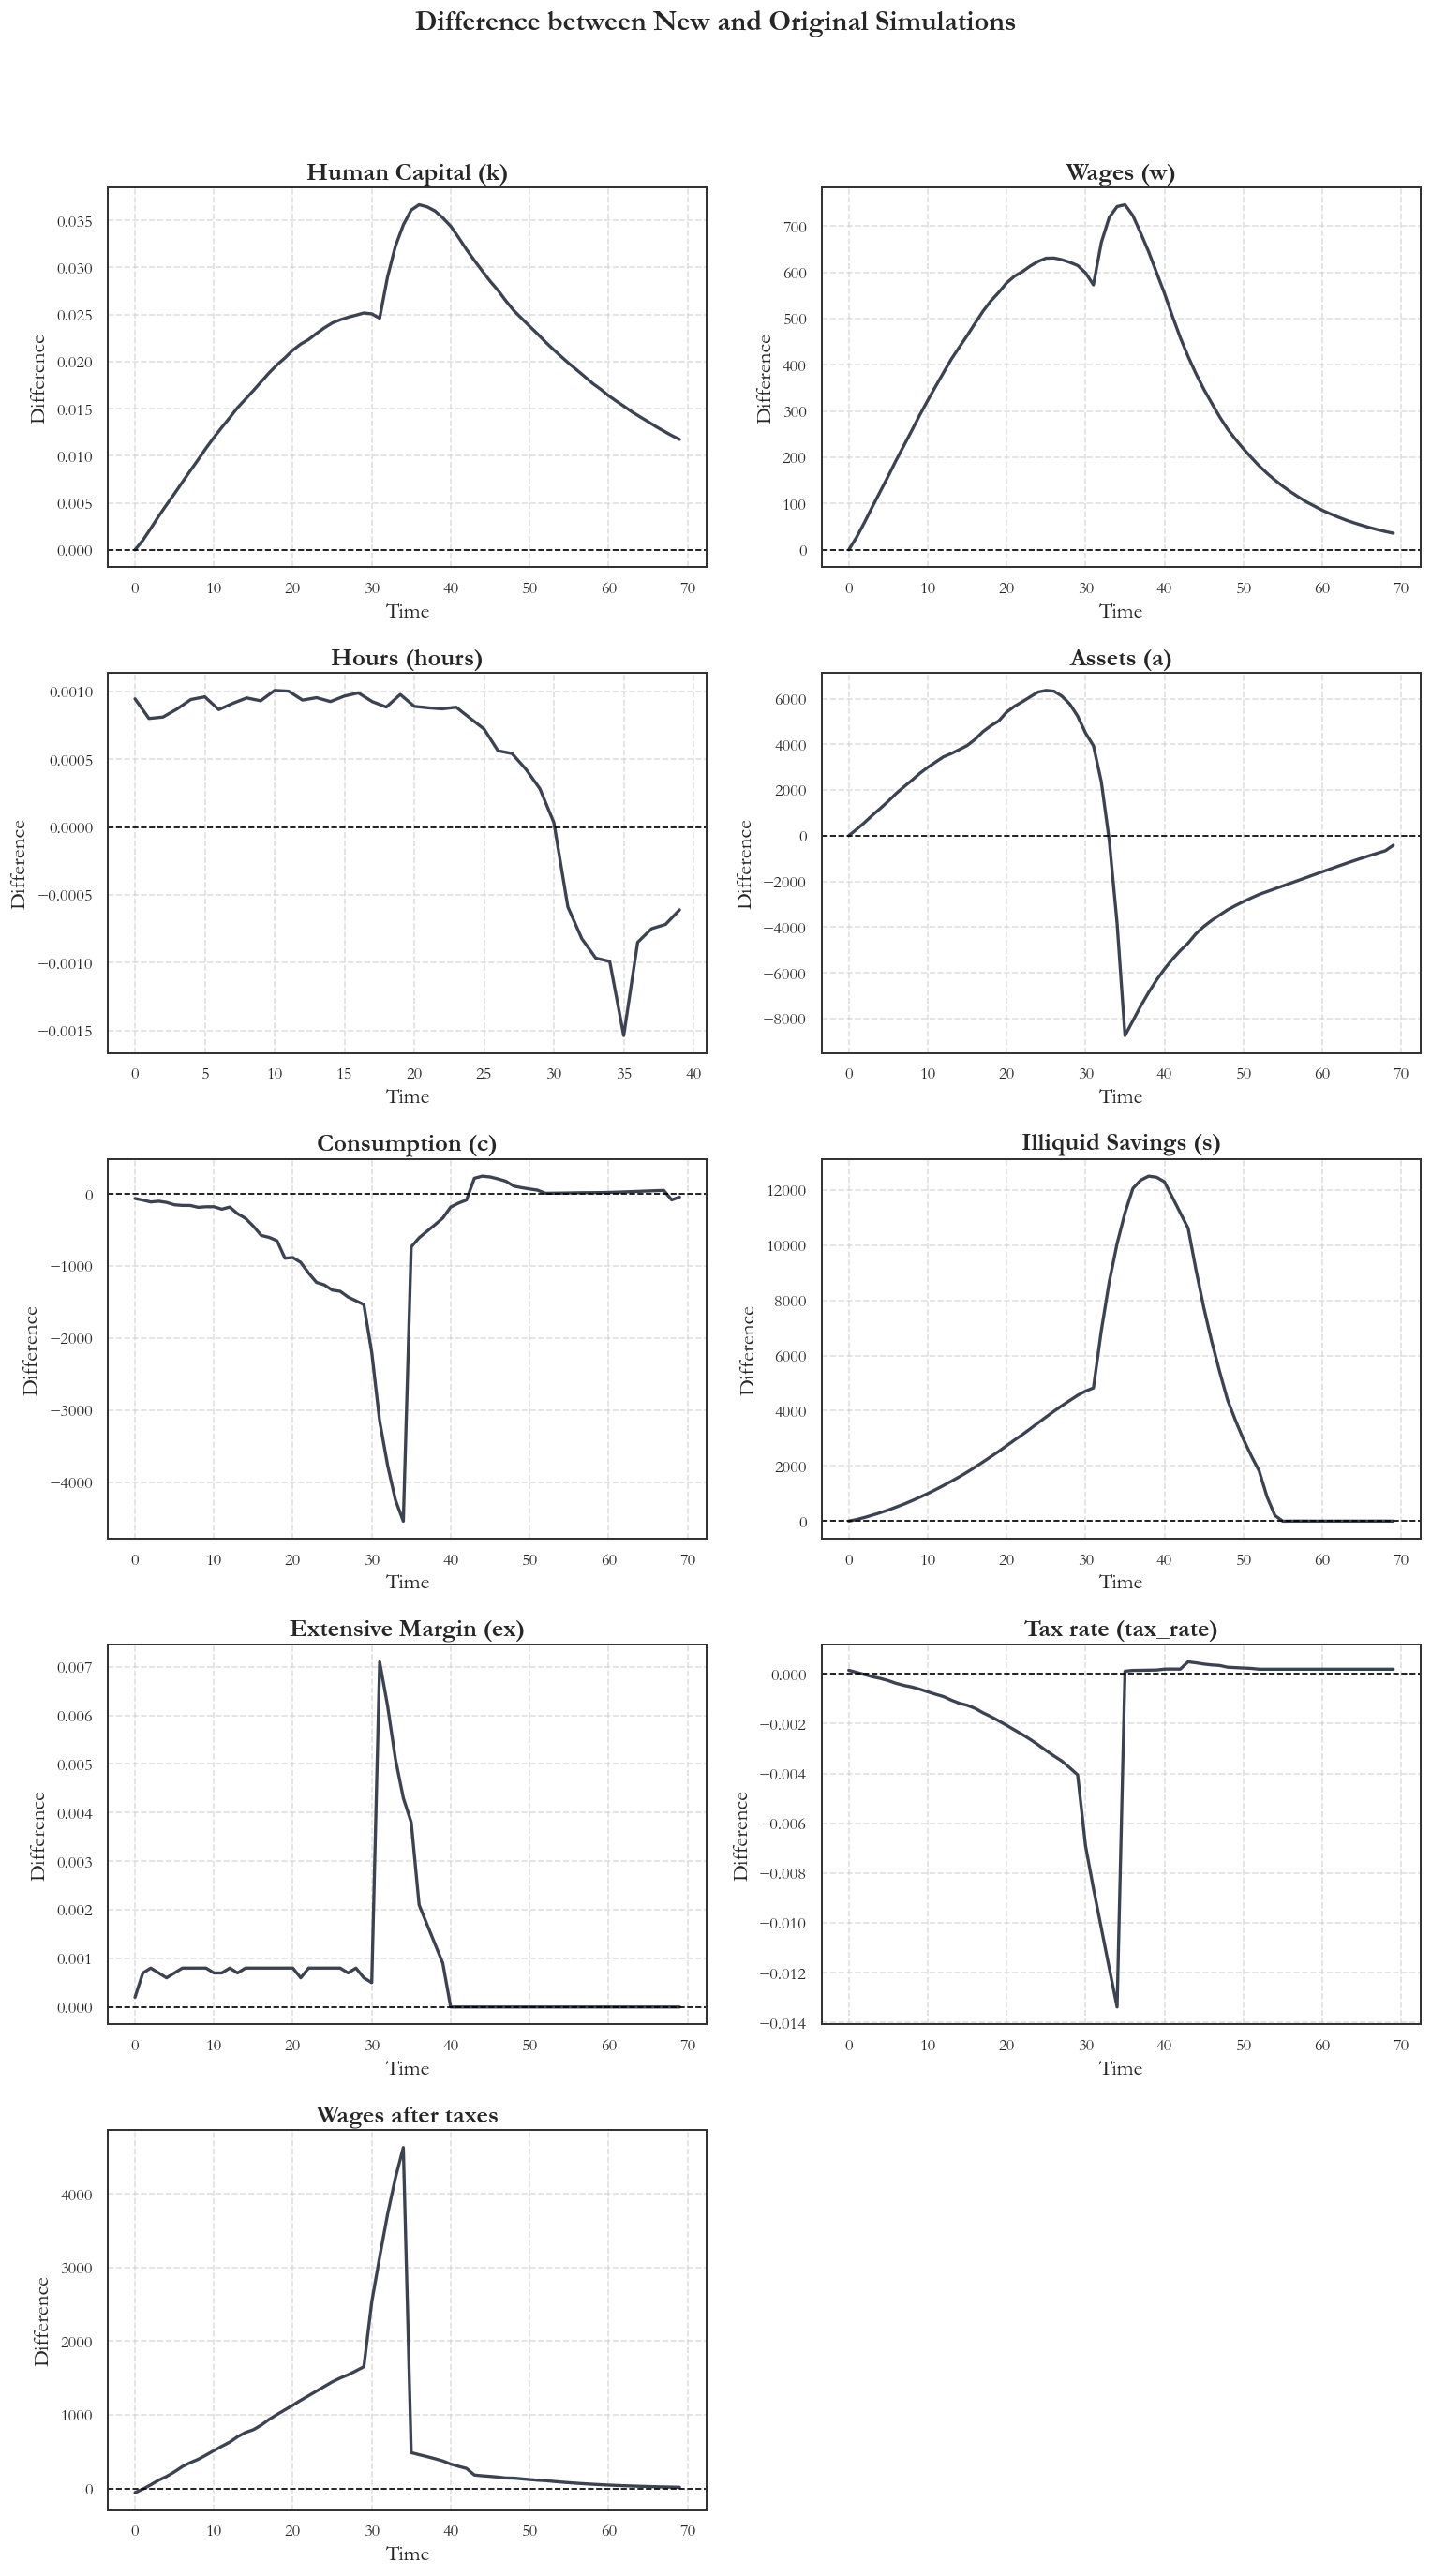

In [33]:

# Full variable set
data_dict_new = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}

data_dict_og = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0),
}

data_dict_diff = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0) - np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0) - np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0)
                    - np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0) - np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0) - np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0) - np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0) - np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0) - np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": (
        np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0)
        - np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0)
    ),
}

plot_comparison_grid(data_dict_og, data_dict_new, time, title="Original vs New Simulations", save_title="counterfactual_full_vars.png")
plot_difference_grid(data_dict_diff, time, title="Difference between New and Original Simulations", save_title="counterfactual_diff_full_vars.png")


In [34]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)


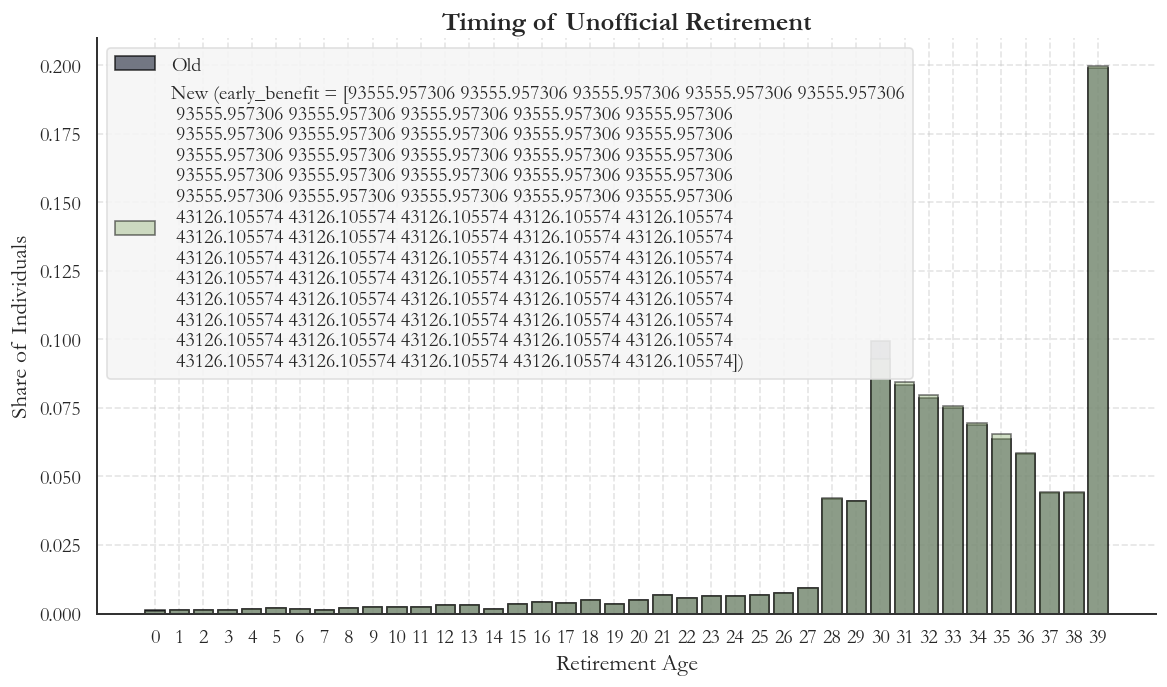

In [35]:
plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    title="Timing of Unofficial Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_retirement_age.png",
)


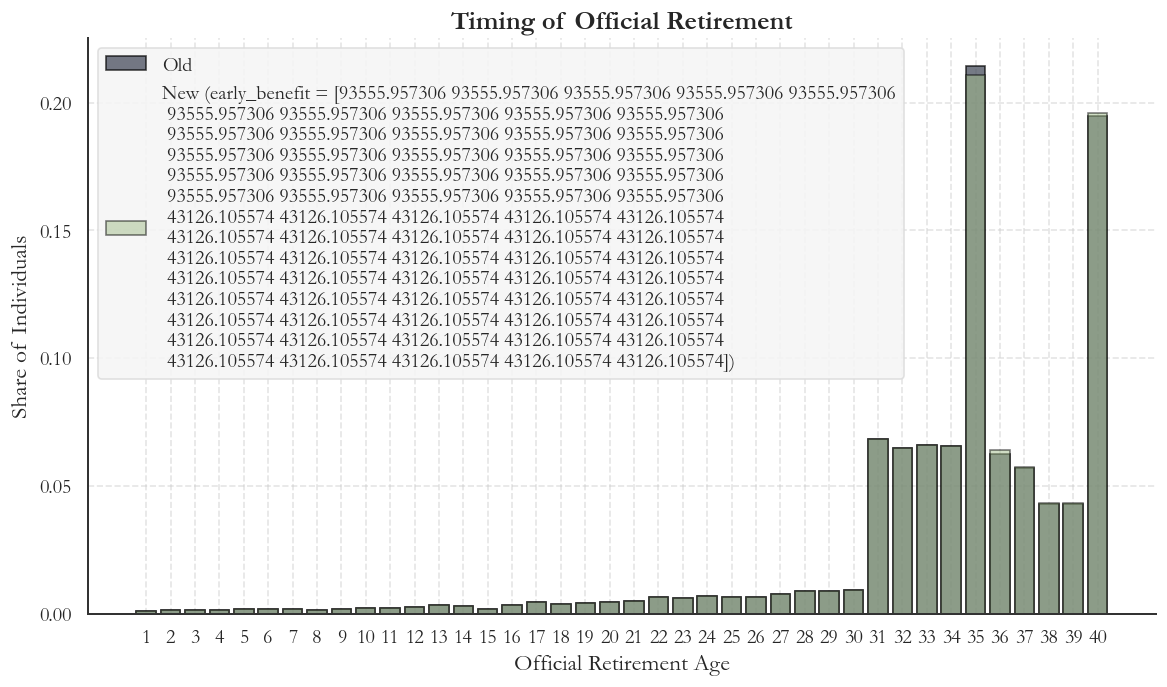

In [36]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(og_model.sim.e.shape[0], np.nan)  # initialize

for i in range(og_model.sim.e.shape[0]):
    retired = np.where(og_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire

first_retirement_new = np.full(new_model.sim.e.shape[0], np.nan)  # initialize

for i in range(new_model.sim.e.shape[0]):
    retired_new = np.where(new_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired_new.size > 0:
        first_retirement_new[i] = retired_new[0]  # first time they retire
plot_event_bar_series(
    values1=first_retirement,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    title="Timing of Official Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_official_retirement_age.png",
)


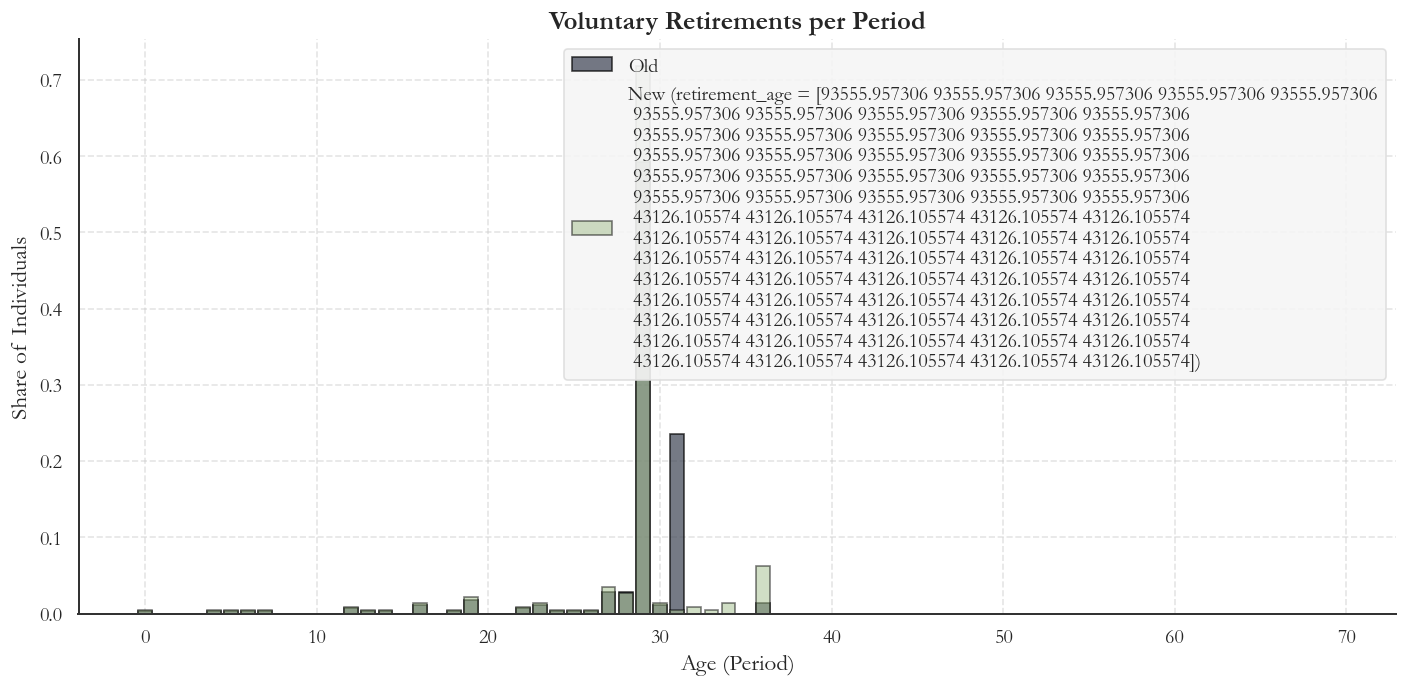

In [37]:
og_ret_counts = np.sum(og_model.sim.ret_flag[:, :], axis=0)
new_ret_counts = np.sum(new_model.sim.ret_flag[:, :], axis=0)
plot_bar_series_comparison(
    og_ret_counts,
    new_ret_counts,
    label1="Old",
    label2=f"New (retirement_age = {theta[0]})",
    title="Voluntary Retirements per Period",
    xlabel="Age (Period)",
    normalize=True,
    save_title="counterfactual_retirement_counts.png",
)


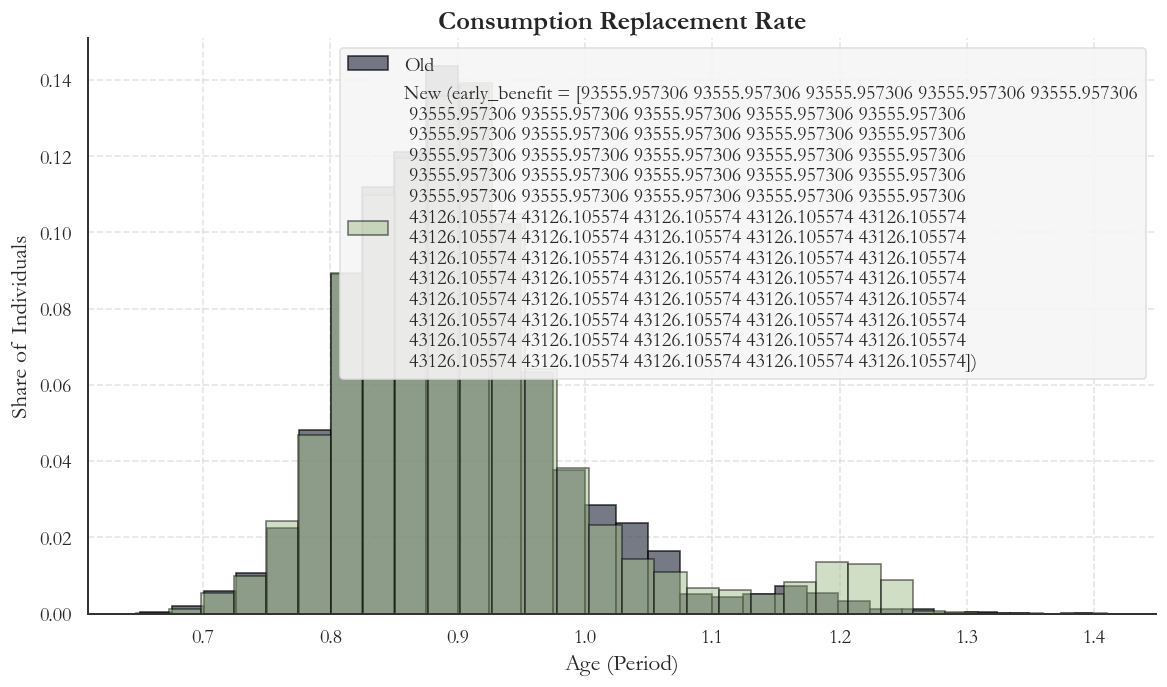

In [38]:
plot_event_histogram(
    values1=consumption_replacement_rate_fct(og_model),
    values2=consumption_replacement_rate_fct(new_model),
    xlabel="Age (Period)",
    title="Consumption Replacement Rate",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    bins=30,
    save_title="counterfactual_consumption_replacement_histogram.png",
)

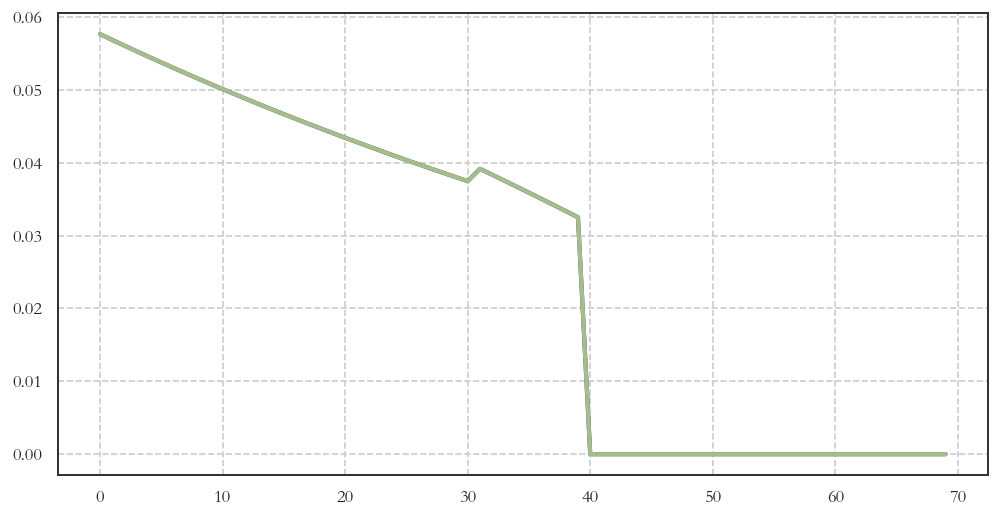

In [39]:
plt.plot(og_model.par.p_e_0)
plt.plot(new_model.par.p_e_0)

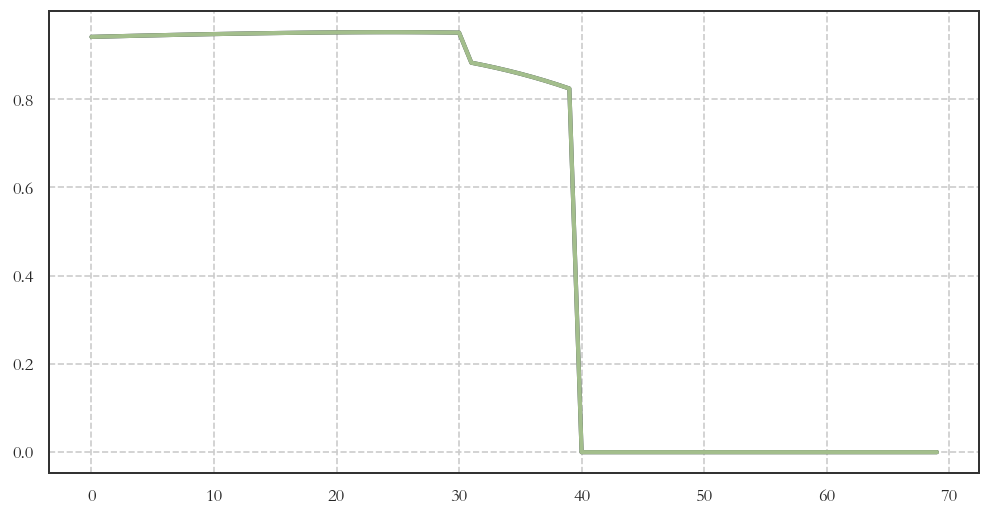

In [40]:
plt.plot(og_model.par.p_e_1)
plt.plot(new_model.par.p_e_1)

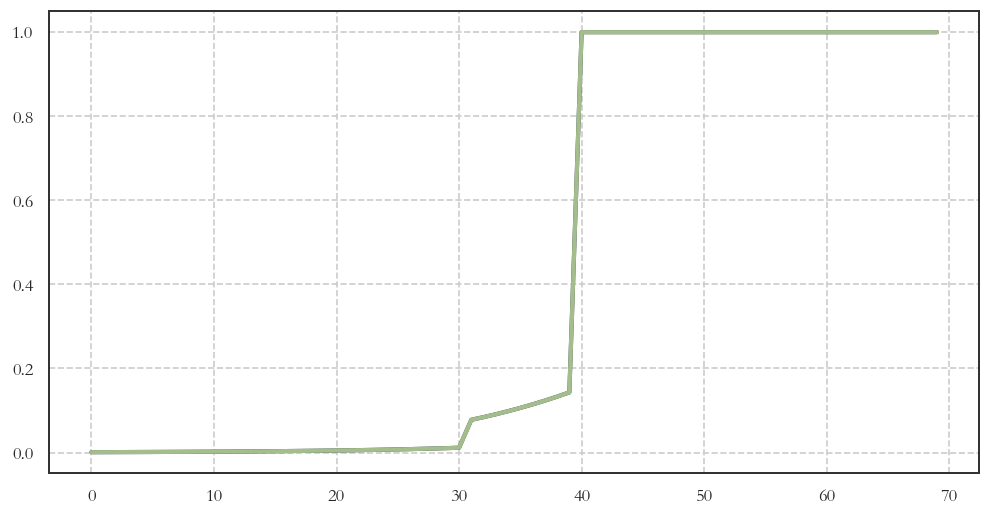

In [41]:
plt.plot(og_model.par.p_e_2)
plt.plot(new_model.par.p_e_2)

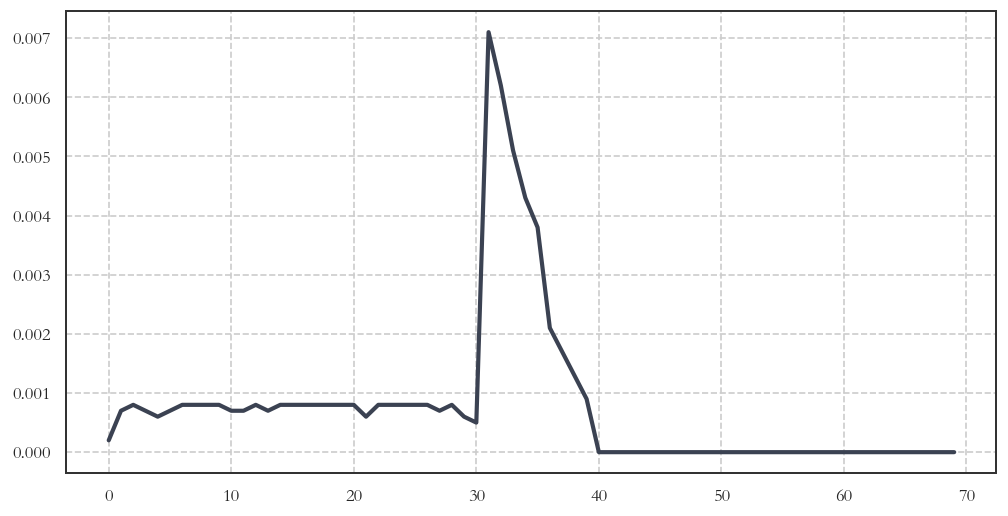

In [42]:
plt.plot(np.mean(new_model.sim.ex, axis=0)-np.mean(og_model.sim.ex, axis=0))

In [43]:
np.mean(new_model.sim.ex, axis=0)

array([0.9215, 0.9226, 0.9268, 0.9197, 0.9195, 0.9233, 0.92  , 0.9198,
       0.9188, 0.9171, 0.9142, 0.9156, 0.9142, 0.9087, 0.9038, 0.9075,
       0.9036, 0.9003, 0.8987, 0.8939, 0.8902, 0.8852, 0.8814, 0.8796,
       0.8715, 0.8644, 0.8581, 0.854 , 0.847 , 0.8382, 0.7979, 0.707 ,
       0.6243, 0.5462, 0.472 , 0.404 , 0.3399, 0.2826, 0.2392, 0.1958,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

# Comparison of retirement age

# replacement rates

In [44]:
assert False

AssertionError: 

# Optimal retirement payments according to welfare

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([1.35e+01, 8.00e-02, 5.00e-04])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

# Optimal retirement payments according to welfare conditioning on pension being the same

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    if np.mean(og_model.sim.s[:, 35]) > np.mean(new_model.sim.s[:, 35]):
        consumption_eq = -9999.9

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([ 2.0, 0.4,  0.001])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

In [ ]:
# constant, beta1, beta2 = np.array([ 1.46922503e+01, -2.31206543e-02,  6.27520107e-04]) # Current optimal giving 0.0065521344388923845 consumption eq.
constant, beta1, beta2 = np.array([ 1.48536631e+01, -4.18610966e-02,  6.47243901e-04]) # Test start


time = np.arange(par.T)

tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

plt.plot(tau)
plt.plot(par.tau)
plt.show()


In [ ]:
theta = [tau]
theta_names = ['tau']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

In [ ]:
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()
